In [1]:
!pip install torch
!pip install transformers
!pip install datasets>=2.11
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install umap-learn
!pip install boto3 --upgrade
!pip install numpy==1.23.5
!pip install -U sentence-transformers
!pip install transformers[torch]
!pip install ipympl

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import datasets
import huggingface_hub
import matplotlib.font_manager as font_manager
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import seaborn as sns
import pprint
from IPython.display import set_matplotlib_formats
from datasets import load_dataset

In [3]:
emotions_dataset = load_dataset("dair-ai/emotion")
print(emotions_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1491: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [4]:
emotions_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
emotions_dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [6]:
emotions_dataset.set_format(type="pandas")
df = emotions_dataset["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
df["label_name"] = df["label"].map(emotions_dataset["train"]
                              .features["label"].int2str)

df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Text(0.5, 1.0, 'Class Distributions')

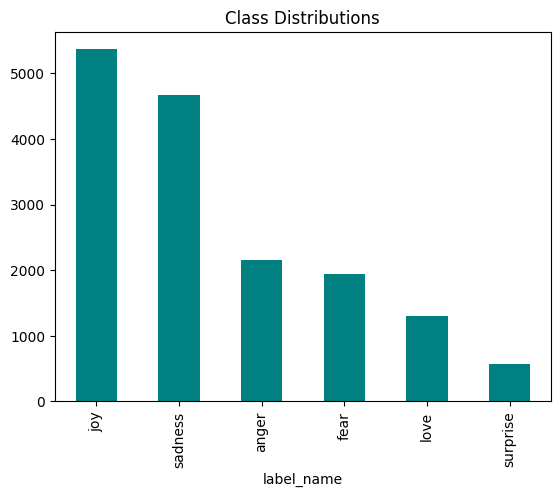

In [8]:
df["label_name"].value_counts().plot(kind="bar", color="teal")
plt.title("Class Distributions")

In [9]:
emotions_dataset.reset_format()

## Tokenization

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

pprint.pprint(tokenize(emotions_dataset["train"][167:169]), compact=True)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]],
 'input_ids': [[101, 1045, 2031, 1037, 3110, 2026, 3193, 3475, 2102, 2183, 2000,
                2022, 2200, 2759, 1998, 2008, 2015, 2986, 102],
               [101, 1045, 2215, 2000, 2907, 2023, 3110, 1997, 7135, 15180,
                1998, 4687, 5091, 102, 0, 0, 0, 0, 0]]}


In [12]:
encoded_emotions_ds = emotions_dataset.map(tokenize,
                                           batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
pprint.pprint(encoded_emotions_ds["train"].features, compact=True)

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None),
                            length=-1,
                            id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None),
                       length=-1,
                       id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear',
                            'surprise'],
                     id=None),
 'text': Value(dtype='string', id=None)}


In [14]:
pprint.pprint(encoded_emotions_ds["train"][:2], compact=True)

{'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0],
                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                     1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0]],
 'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                0, 0, 0, 0

In [15]:
from transformers import AutoModel

model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [16]:
def get_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [17]:
encoded_emotions_ds.set_format("torch",
                    columns=["input_ids", "attention_mask", "label"])

hidden_emotions_ds = encoded_emotions_ds.map(get_hidden_states,
                                             batched=True)

hidden_emotions_ds["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [18]:
import numpy as np

X_train = np.array(hidden_emotions_ds["train"]["hidden_state"])
X_valid = np.array(hidden_emotions_ds["validation"]["hidden_state"])
y_train = np.array(hidden_emotions_ds["train"]["label"])
y_valid = np.array(hidden_emotions_ds["validation"]["label"])

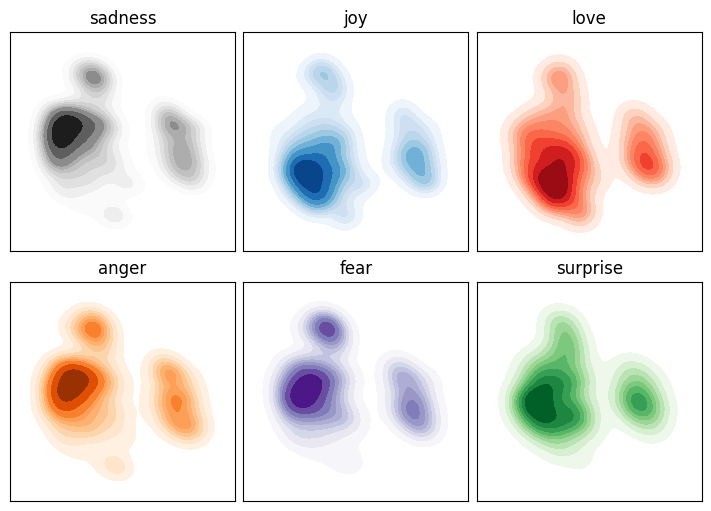

In [19]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
new_embed = pd.DataFrame(mapper.embedding_, columns=["X", "Y"]).assign(label=y_train)

fig, axes = plt.subplots(2, 3, figsize=(7, 5),
                         constrained_layout=True,
                         subplot_kw=dict(xticks=[], yticks=[], xlabel=None, ylabel=None))

axes = axes.flatten()

cmaps = ["Greys", "Blues", "Reds", "Oranges", "Purples", "Greens"]
labels = emotions_dataset["train"].features["label"].names

for label, cmap, ax in zip(labels, cmaps, axes):
    sns.kdeplot(data=new_embed.query(f"label=={labels.index(label)}"),
                x="X", y="Y", cmap=cmap, fill=True, ax=ax)

    ax.set_title(label)

plt.show()

In [20]:
from huggingface_hub import notebook_login
notebook_login()

In [21]:
from transformers import (
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = len(set(emotions_dataset["train"].features["label"].names))

model = AutoModelForSequenceClassification \
        .from_pretrained(model_checkpoint, num_labels=num_labels).to(device)

batch_size = 64

logging_steps = len(encoded_emotions_ds["train"]) // batch_size

model_name = f"DistilBERT-finetuned-on-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
training_args.output_dir

'DistilBERT-finetuned-on-emotion'

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded_emotions_ds["train"],
    eval_dataset=encoded_emotions_ds["validation"],
    tokenizer=tokenizer
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.846300,0.322103,0.903500,0.902766
2,0.249500,0.217249,0.928000,0.927994


TrainOutput(global_step=500, training_loss=0.5478775100708008, metrics={'train_runtime': 256.1101, 'train_samples_per_second': 124.946, 'train_steps_per_second': 1.952, 'total_flos': 720342861696000.0, 'train_loss': 0.5478775100708008, 'epoch': 2.0})

In [28]:
predicted_outputs = trainer.predict(encoded_emotions_ds["validation"])
predicted_outputs.metrics

{'test_loss': 0.21724854409694672,
 'test_accuracy': 0.928,
 'test_f1': 0.927994117139087,
 'test_runtime': 4.3193,
 'test_samples_per_second': 463.039,
 'test_steps_per_second': 7.409}

In [29]:
y_preds = np.argmax(predicted_outputs.predictions, axis=1)

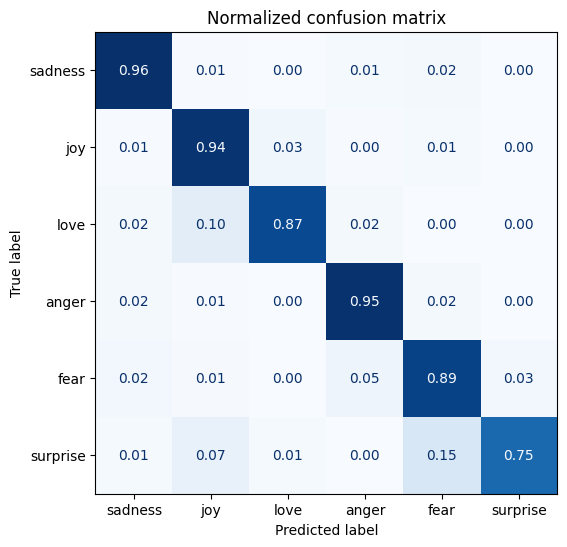

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
plot_confusion_matrix(y_preds, y_valid, labels)


In [31]:
trainer.push_to_hub(commit_message="model finetunned!")

events.out.tfevents.1717983424.a176a037865d.903.0:   0%|          | 0.00/6.52k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/waniabbeer/DistilBERT-finetuned-on-emotion/commit/f115691dddc7b9249c291e4e95bf14c68da38880', commit_message='model finetunned!', commit_description='', oid='f115691dddc7b9249c291e4e95bf14c68da38880', pr_url=None, pr_revision=None, pr_num=None)

In [32]:
from transformers import pipeline

model_path = "waniabbeer/DistilBERT-finetuned-on-emotion"
classifier = pipeline("text-classification", model=model_path)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [33]:


from sklearn.metrics import classification_report

# Get the predictions and true labels
y_pred = np.argmax(predicted_outputs.predictions, axis=1)
y_true = emotions_dataset["validation"]["label"]

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

     sadness       0.97      0.96      0.96       550
         joy       0.96      0.94      0.95       704
        love       0.86      0.87      0.86       178
       anger       0.92      0.95      0.93       275
        fear       0.83      0.89      0.86       212
    surprise       0.90      0.75      0.82        81

    accuracy                           0.93      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.93      0.93      0.93      2000

